# Data Loading and Plotting example

In [2]:
%matplotlib inline
import numpy as np
import matplotlib as plt
import sys 
import math
import tensorflow as tf
sys.path.insert(0,'..')
from utils import plot_stroke
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [3]:
#Sigmoid
def sigmoid(x):                                        
    return 1 / (1 + np.exp(x))

In [4]:
strokes = np.load('../data/strokes.npy')
with open('../data/sentences.txt') as f:
    texts = f.readlines()

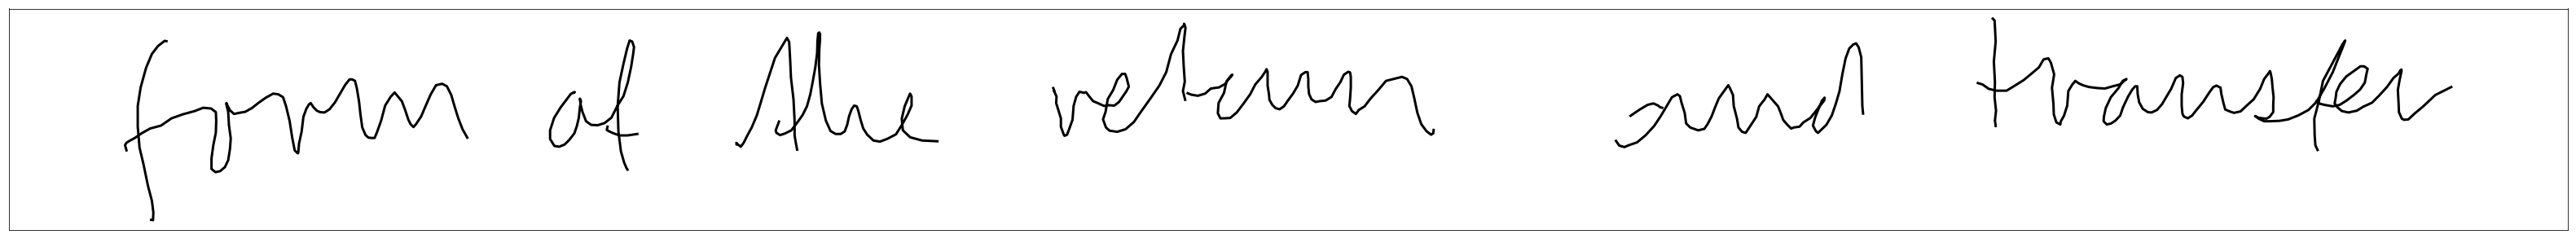

TEXT: form of the retain and transfer



In [5]:
idx = 44
stroke = strokes[idx]
text = texts[idx]
plot_stroke(stroke)
print 'TEXT:', text

### Strokes

Each handwritten sentence is represented as a 2D array with T rows and 3 columns. T is the number of timesteps. The first column represents whether to interrumpt the current stroke (i.e. when the pen is lifted off the paper). The second and third columns represent the relative coordinates of the new point with respect to the last point. Please have a look at the plot_stroke if you want to understand how to plot this sequence.

In [6]:
print(np.shape(strokes[0:50]))
strokes[263][1]

(50,)


array([ 0.  , -0.2 ,  0.05], dtype=float32)

In [7]:
lstm_sizes =[30]
nb_mixture = 10
batch_size = 10
len_sequence = None

In [8]:
def model_inputs():

    input_data = tf.placeholder(dtype=tf.float32,
                                 shape=[None,None,3], name="input_data")
    target_data = tf.placeholder(dtype=tf.float32,
                                 shape=[None, None ,3], name='targets')
    keep_prob =   tf.placeholder(dtype=tf.float32, name='keep_prob')
    
    return input_data, target_data, keep_prob

In [9]:
input_data, target_data, keep_prob = model_inputs()
print(np.shape(target_data))

(?, ?, 3)


In [10]:
def build_lstm_layers(lstm_sizes, X, keep_prob_, batch_size):
  
    lstms = [tf.contrib.rnn.BasicLSTMCell(size) for size in lstm_sizes]
    # Add dropout to the cell
    drops = [tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob_) for lstm in lstms]
    # Stack up multiple LSTM layers, for deep learning
    cell = tf.contrib.rnn.MultiRNNCell(drops)
    # Getting an initial state of all zeros
    initial_state = cell.zero_state(batch_size, tf.float32)
    
    lstm_outputs, final_state = tf.nn.dynamic_rnn(cell, 
                                                  inputs = X, 
                                                  initial_state=initial_state)
    return initial_state, lstm_outputs, cell, final_state

In [11]:
initial_state, lstm_outputs, cell, final_state = build_lstm_layers(lstm_sizes, input_data, keep_prob, batch_size)

Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').


In [12]:
def build_output(lstm_outputs):
    output_w = tf.Variable(tf.random_normal([30, 6*nb_mixture+1]))
    output_b = tf.Variable(tf.zeros([6*nb_mixture+1]))
    output = tf.nn.xw_plus_b(lstm_outputs[:, -1], output_w, output_b)
    return output, output_w, output_b

In [13]:
output, output_w, output_b = build_output(lstm_outputs)
print (np.shape(lstm_outputs[:, -1]))
print (np.shape(output))

(10, 30)
(10, 61)


In [14]:
def get_mixture_coef(output):
            # returns the tf slices containing mdn dist params
            # ie, eq 18 -> 23 of http://arxiv.org/abs/1308.0850
            z = output
            z_eos = z[:, 0:1]
            z_pi, z_mu1, z_mu2, z_sigma1, z_sigma2, z_corr = tf.split(
                axis=1, num_or_size_splits=6, value=z[:, 1:])

            # process output z's into MDN paramters

            # end of stroke signal
            z_eos = tf.sigmoid(z_eos)  # should be negated, but doesn't matter.

            # softmax all the pi's:
            max_pi = tf.reduce_max(z_pi, 1, keep_dims=True)
            z_pi = tf.subtract(z_pi, max_pi)
            z_pi = tf.exp(z_pi)
            normalize_pi = tf.reciprocal(
                tf.reduce_sum(z_pi, 1, keep_dims=True))
            z_pi = tf.multiply(normalize_pi, z_pi)

            # exponentiate the sigmas and also make corr between -1 and 1.
            z_sigma1 = tf.exp(z_sigma1)
            z_sigma2 = tf.exp(z_sigma2)
            z_corr = tf.tanh(z_corr)

            return z_pi, z_mu1, z_mu2, z_sigma1, z_sigma2, z_corr, z_eos

In [15]:
[z_pi, z_mu1, z_mu2, z_sigma1, z_sigma2, z_corr, z_eos] = get_mixture_coef(output)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [16]:
def tf_2d_normal(x1, x2, mu1, mu2, s1, s2, rho):
            # eq # 24 and 25 of http://arxiv.org/abs/1308.0850
            norm1 = tf.subtract(x1, mu1)
            norm2 = tf.subtract(x2, mu2)
            s1s2 = tf.multiply(s1, s2)
            z = tf.square(tf.div(norm1, s1)) + tf.square(tf.div(norm2, s2)) - \
                2 * tf.div(tf.multiply(rho, tf.multiply(norm1, norm2)), s1s2)
            negRho = 1 - tf.square(rho)
            result = tf.exp(tf.div(-z, 2 * negRho))
            denom = 2 * np.pi * tf.multiply(s1s2, tf.sqrt(negRho))
            result = tf.div(result, denom)
            return result

In [17]:
def get_lossfunc(
                z_pi,
                z_mu1,
                z_mu2,
                z_sigma1,
                z_sigma2,
                z_corr,
                z_eos,
                x1_data,
                x2_data,
                eos_data):
            result0 = tf_2d_normal(
                x1_data,
                x2_data,
                z_mu1,
                z_mu2,
                z_sigma1,
                z_sigma2,
                z_corr)
            # implementing eq # 26 of http://arxiv.org/abs/1308.0850
            epsilon = 1e-20
            result1 = tf.multiply(result0, z_pi)
            result1 = tf.reduce_sum(result1, 1, keep_dims=True)
            # at the beginning, some errors are exactly zero.
            result1 = -tf.log(tf.maximum(result1, 1e-20))

            result2 = tf.multiply(z_eos, eos_data) + \
                tf.multiply(1 - z_eos, 1 - eos_data)
            result2 = -tf.log(result2)

            result = result1 + result2
            return tf.reduce_sum(result)

In [18]:
target_data_new = tf.reshape(target_data, [-1, 3])
[x1_data, x2_data, eos_data] = tf.split(
            axis=1, num_or_size_splits=3, value=target_data_new)
z_pi, z_mu1, z_mu2, z_sigma1, z_sigma2, z_corr, z_eos = get_mixture_coef(output)
loss = get_lossfunc(z_pi, z_mu1, z_mu2, z_sigma1, z_sigma2, z_corr, z_eos ,x1_data, x2_data, eos_data)

train_op = tf.train.AdamOptimizer().minimize(loss)

In [19]:
sess = tf.Session(config = config)
sess.run(tf.initialize_all_variables())
x_batch = []
y_batch = []
for i in range (batch_size):
    x_batch.append(strokes[i][0:300])
    y_batch.append(strokes[i][1:301])
x_data = x_batch
y_data = y_batch
state = sess.run(initial_state)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [ ]:
NEPOCH = 1
loss = np.zeros(NEPOCH) # store the training progress here.
for i in range(NEPOCH):
    sess.run(train_op,
             feed_dict=
             {
                input_data: x_data, 
                target_data: y_data,
              
             })
    
    loss[i] = sess.run(loss, feed_dict={input_data: x_data,
                                        target_data: y_data})
    print (loss[i])

In [ ]:
oneDivSqrtTwoPI = 1 / math.sqrt(2*math.pi) # normalisation factor for gaussian, not needed.
def tf_normal(y, mu, sigma):
  result = tf.sub(y, mu)
  result = tf.mul(result,tf.inv(sigma))
  result = -tf.square(result)/2
  return tf.mul(tf.exp(result),tf.inv(sigma))*oneDivSqrtTwoPI

def get_lossfunc(out_pi, out_sigma, out_mu, y):
  result = tf_normal(y, out_mu, out_sigma)
  result = tf.mul(result, out_pi)
  result = tf.reduce_sum(result, 1, keep_dims=True)
  result = -tf.log(result)
  return tf.reduce_mean(result)

In [ ]:
# GRADED FUNCTION: initialize_parameters

def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns: 
    parameters -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(1)
    
    ### START CODE HERE ### (≈ 4 lines of code)
    Whx = np.random.randn(n_h,n_x)*0.01
    bh = np.zeros((n_h,1))
    Whh = np.random.randn(n_h,n_h)*0.01
    Wyh = np.random.randn(n_y,n_h)*0.01
    by = np.zeros((n_y,1))
    ### END CODE HERE ###
    
    assert(Whx.shape == (n_h, n_x))
    assert(bh.shape == (n_h, 1))
    assert(Whh.shape == (n_h, n_h))
    assert(Wyh.shape== (n_y,n_h))
    assert(by.shape == (n_y, 1))
    
    parameters = {"Whx": Whx,
                  "bh": bh,
                  "Whh": Whh,
                  "Wyh": Wyh,
                   "by": by
                         }
    
    return parameters    

In [ ]:
parameters = initialize_parameters(3,200,121)
print("shape Whx = " + str(np.shape(parameters["Whx"])))
print("shape Whh = " + str(np.shape(parameters["Whh"])))
print("shape Wyh = " + str(np.shape(parameters["Wyh"])))

In [ ]:
def linear_forward(h, X, Wx, Wh, bh):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    ### START CODE HERE ### (≈ 1 line of code)
    Z = np.dot(Wh,A) + np.dot(Wx,X) + bh
    ### END CODE HERE ###
    
    assert(Z.shape == (Wx.shape[0], h.shape[1]))
    cache = (h, Wx, Wh, b)
    
    return Z, cache

In [ ]:
def linear_activation_forward(h_prev, X, Wx, Wh, bh):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        ### START CODE HERE ### (≈ 2 lines of code)
    Z, linear_cache = linear_forward(h_prev, X, Wx, Wh, bh)[0], linear_forward(h_prev, X, Wx, Wh, bh)[1]
    h, activation_cache = sigmoid(Z)[0], sigmoid(Z)[1]
        ### END CODE HERE ###
    
    
    assert (h.shape == (Wx.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return h, cache

In [ ]:
def compute_output(Y, nb_mixtures):
    shapeY = np.shape(Y)
    W=np.zeros((nb_mixtures,1))
    mu=np.zeros((nb_mixtures,2))
    s=np.zeros((nb_mixtures,2))
    ro=np.zeros((nb_mixtures,1))
    
    e=sigmoid(Y[0])
    index = 1
    sum_weight = 0
    for j in range (nb_mixtures):
        W[j] = np.exp(Y[index])
        sum_weight = sum_weight + W[j]
        
        mu[j][0]=Y[index+1]
        mu[j][1]=Y[index+2]
        s[j][0]=np.exp(Y[index+3])
        s[j][1]=np.exp(Y[index+4])
        ro[j]=np.tanh(Y[index+5])
        index = index + 6
    W = W/sum_weight
    
    return e, W ,mu ,s ,ro      

In [ ]:
Y = np.zeros((121, 1))
e, W ,mu ,s, ro = compute_output(Y, 20)

In [ ]:
def compute_probability(X, e, W, mu, s, ro, nb_mixtures):
    result = 0
    index = 1
    Z = np.zeros((nb_mixtures))
    N = np.zeros((nb_mixtures))
    for j in range (nb_mixtures):
        Z[j] = ((X[1] - mu[j][0])/s[j][0])**2 + ((X[2] - mu[j][1])/s[j][1])**2 - 2*ro[j]*(X[1]-mu[j][0])*(X[2]-mu[j][1])/(s[j][0]*s[j][1]) 
        N[j] = (1/(2*np.pi*s[j][0]*s[j][1]*np.sqrt(1-ro[j]**2)))*np.exp(- Z[j]/(2*(1-ro[j]**2)))
        result = result + W[j]*N[j]
    
    if X[0]==[1]:
        probability = result*e
    else : 
        probability = result*(1-e)
        
    return N , probability, result

In [ ]:
X = [[1], [1.34], [0]]
N, result = compute_probability(X,e, W ,mu ,s, ro, 20)
print(result)

In [ ]:
def compute_cost(X_stroke):
    T = np.shape(X_stroke)[0]
    cost = 0
    for t in range (T):
        cost = cost + np.log(compute_probability(X_stroke[t],compute_output))